In [1]:
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import itertools

from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# If we want to consider inf and -inf to be “NA” in computations, we can set 
pd.options.mode.use_inf_as_na = True

In [2]:
train_df = pd.read_csv('data/aps_failure_training_set.csv', skiprows=range(0, 20))
test_df = pd.read_csv('data/aps_failure_test_set.csv', skiprows=range(0, 20))

In [3]:
# replace classes neg to 0, pos to 1
# alternative index accesing train_df.iloc[:,0]
train_df['class'] = train_df['class'].str.replace('neg','0')
train_df['class'] = train_df['class'].str.replace('pos','1')
cols = train_df.columns
train_df[cols] = train_df[cols].apply(pd.to_numeric, errors='coerce')

test_df['class'] = test_df['class'].str.replace('neg','0')
test_df['class'] = test_df['class'].str.replace('pos','1')
cols = test_df.columns
test_df[cols] = test_df[cols].apply(pd.to_numeric, errors='coerce')

In [4]:
# split dataframe into two arrays
cols = train_df.columns.drop('class')
X_train = train_df[cols].values
X_test = test_df[cols].values

# labels
y_train = train_df['class'].values
y_test = test_df['class'].values

In [5]:
imp_train = Imputer(missing_values='NaN', strategy='median', axis=0)
imp_train = imp_train.fit(X_train)
imp_test = Imputer(missing_values='NaN', strategy='median', axis=0)
imp_test = imp_test.fit(X_test)
# Impute each train and test item, then predict
X_train_imp = imp_train.transform(X_train)
X_test_imp = imp_test.transform(X_test)

In [6]:
# LocalOutlierFactor
# http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(X_train_imp)
X = X_train_imp[y_pred > 0]
y = y_train[y_pred > 0]

In [7]:
# number of features with min costs (see ScaniaKNearestDimentions)
k = 96
# select features
X_kbest_train = SelectKBest(chi2, k=91).fit_transform(X, y)
X_kbest_test = SelectKBest(chi2, k=91).fit_transform(X_test_imp, y_test)

In [8]:
print('Class distribution of the whole set: {}'.format(Counter(y)))

Class distribution of the whole set: Counter({0: 53252, 1: 748})


### Combination of over- and under-sampling
http://contrib.scikit-learn.org/imbalanced-learn/stable/combine.html#

In [9]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
t0 = time()
X_resampled, y_resampled = smote_enn.fit_sample(X_kbest_train, y)
print(sorted(Counter(y_resampled).items()), "resampling time:",  round(time()-t0, 3))

[(0, 51776), (1, 53196)] resampling time: 110.312


### K-Neighbors Classifier with original data (applied only outlier deletion)
http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [10]:
times_train = []
times_pred = []
Cost_1 = 10 
Cost_2 = 500
costs = []

neighbors_list = range(3, 25)

for neighbors in neighbors_list:
    neigh = KNeighborsClassifier(n_neighbors=neighbors)
    print('-- Number of neighbors for K-Neighbors Classifier: {} --'.format(neighbors))
    t0 = time()
    n_clf = neigh.fit(X, y)
    train_time = round(time()-t0, 3)
    times_train.append(train_time)
    print('\tTrain time:', round(time()-t0, 3))

    t1 = time()
    y_pred = n_clf.predict(X_test_imp)
    times_pred.append(round(time()-t0, 3))
    predict_time = round(time()-t1, 3)
    print('\tPredict time:', predict_time)

    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    FP = cnf_matrix[0, 1]
    FN = cnf_matrix[1, 0]
    Total_cost = (Cost_1*FP + Cost_2*FN)/len(y_pred)
    print('\tTotal cost:', Total_cost)
    costs.append(Total_cost)

-- Number of neighbors for K-Neighbors Classifier: 3 --
	Train time: 3.979
	Predict time: 27.219
	Total cost: 6.159375
-- Number of neighbors for K-Neighbors Classifier: 4 --
	Train time: 4.011
	Predict time: 28.586
	Total cost: 7.673125
-- Number of neighbors for K-Neighbors Classifier: 5 --
	Train time: 3.931
	Predict time: 29.039
	Total cost: 6.804375
-- Number of neighbors for K-Neighbors Classifier: 6 --
	Train time: 3.972
	Predict time: 29.104
	Total cost: 7.798125
-- Number of neighbors for K-Neighbors Classifier: 7 --
	Train time: 3.5
	Predict time: 28.343
	Total cost: 6.961875
-- Number of neighbors for K-Neighbors Classifier: 8 --
	Train time: 3.504
	Predict time: 29.297
	Total cost: 7.830625
-- Number of neighbors for K-Neighbors Classifier: 9 --
	Train time: 3.472
	Predict time: 29.589
	Total cost: 7.0525
-- Number of neighbors for K-Neighbors Classifier: 10 --
	Train time: 3.45
	Predict time: 30.081
	Total cost: 7.859375
-- Number of neighbors for K-Neighbors Classifier: 1

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\envs\ML36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


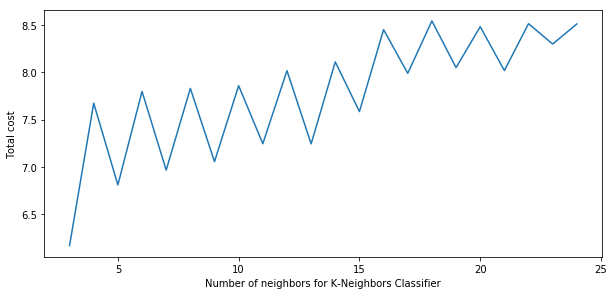

In [11]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)
ax = plt.subplot(211)
ax.plot(neighbors_list, costs)
plt.ylabel('Total cost')
plt.xlabel('Number of neighbors for K-Neighbors Classifier')
plt.show()

### K-Neighbors Classifier with original data with reduced number of dimentions

In [12]:
# default parameters
neigh = KNeighborsClassifier(n_neighbors=5)

In [13]:
t0 = time()
n_clf_unbal = neigh.fit(X_kbest_train, y) 
print('Train time', round(time()-t0, 3))
t1 = time()
y_pred_unbal = n_clf_unbal.predict(X_kbest_test)
print('Predict time', round(time()-t1, 3))

TypeError: 'module' object is not callable

### K-Neighbors Classifier with resampled data and reduced number of dimentions

In [ ]:
t0 = time()
n_clf_bal = neigh.fit(X_resampled, y_resampled) 
print('Train time', round(time()-t0, 3))
t1 = time()
y_pred_bal = n_clf_bal.predict(X_kbest_test)
print('Predict time', round(time()-t1, 3))

### Evaluation

In [ ]:
print('test labels: \n', sorted(Counter(y_test).items()))
print('predicted labels original dataset with not reduced dimentions: \n', sorted(Counter(y_pred_unbal).items()))
print('predicted labels unbalanced dataset: \n', sorted(Counter(y_pred_unbal).items()))
print('predicted labels alanced dataset: \n', sorted(Counter(y_pred_bal).items()))

In [ ]:
acc_unbal = metrics.accuracy_score(y_pred_unbal, y_test)
print ("accuracy score of the  model trained on original dataset:", acc_unbal)
acc_bal = metrics.accuracy_score(y_pred_bal, y_test)
print ("accuracy score of the  model trained on resampled dataset:", acc_bal)

In [ ]:
# calculate null accuracy (for binary classification problems coded as 0/1)# calcul 
max(y_test.mean(), 1 - y_test.mean())

Classification accuracy is the easiest classification metric to understand<br>
But, it does not tell you the underlying distribution of response values<br>
And, it does not tell you what "types" of errors your classifier is making<br>

In [ ]:
# Compute confusion matrix original dataset
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# Compute confusion matrix unbalanced dataset
cnf_matrix_unbal = metrics.confusion_matrix(y_test, y_pred_unbal)
# Compute confusion matrix balanced dataset
cnf_matrix_bal = metrics.confusion_matrix(y_test, y_pred_bal)
np.set_printoptions(precision=2)

# save confusion matrix and slice into four pieces
TP = cnf_matrix[1, 1]
TN = cnf_matrix[0, 0]
FP = cnf_matrix[0, 1]
FN = cnf_matrix[1, 0]
print("Original data, TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}".format(tp = TP, tn = TN, fp = FP, fn = FN))

# save confusion matrix and slice into four pieces
TP_unbal = cnf_matrix_unbal[1, 1]
TN_unbal = cnf_matrix_unbal[0, 0]
FP_unbal = cnf_matrix_unbal[0, 1]
FN_unbal = cnf_matrix_unbal[1, 0]
print("Unbalanced data, TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}".format(tp = TP_unbal, tn = TN_unbal, fp = FP_unbal, fn = FN_unbal))

# save confusion matrix and slice into four pieces
TP_bal = cnf_matrix_bal[1, 1]
TN_bal = cnf_matrix_bal[0, 0]
FP_bal = cnf_matrix_bal[0, 1]
FN_bal = cnf_matrix_bal[1, 0]
print("Balanced data, TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}".format(tp = TP_bal, tn = TN_bal, fp = FP_bal, fn = FN_bal))

In [ ]:
Cost_1 = 10 
Cost_2 = 500
Total_cost = (Cost_1*FP + Cost_2*FN)/len(y_pred)
Total_cost_unbalanced = (Cost_1*FP_unbal + Cost_2*FN_unbal)/len(y_pred)
Total_cost_balanced = (Cost_1*FP_bal + Cost_2*FN_bal)/len(y_pred)

print("Total cost:", Total_cost)
print("Total cost unbalanced:", Total_cost_unbalanced)
print("Total cost balanced:", Total_cost_balanced)

In [ ]:
# Plot confusion matrix to evaluate the accuracy of a classification
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = (['Neg', 'Pos'])
   

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, classifier on original dataset')
    
plt.figure()
plot_confusion_matrix(cnf_matrix_unbal, classes=class_names,
                      title='Confusion matrix, with unbalanced classifier')

plt.figure()
plot_confusion_matrix(cnf_matrix_bal, classes=class_names,
                      title='Confusion matrix, with balanced classifier')



# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

+ Every observation in the testing set is represented in exactly one box
+ It's a 2x2 matrix because there are 2 response classes
+ The format shown here is not universal

Basic terminology <br>

+ True Positives (TP): we correctly predicted that there is some failure
+ True Negatives (TN): we correctly predicted that there is no failure
+ False Positives (FP): we incorrectly predicted that there is some failure (a "Type I error")
+ False Negatives (FN): we incorrectly predicted that there is no failure (a "Type II error")

#### Conclusion:

+ Confusion matrix gives you a more complete picture of how your classifier is performing
+ Also allows you to compute various classification metrics, and these metrics can guide your model selection